In [3]:
from models.models import GerstnerWaves
from models.simulation import DataGeneration

from estimators.pipeline import Pipeline

from utils.plots import GerstnerWavesPlots
from utils.utils import get_min_loss

from config import configuration

import torch

In [26]:
#Set configuration
data_config_name = 'default_r1'
ekf_config_name = 'ekf_default'
training_config_name = 'default_wd1e-6'
knet_config_name = 'knet_default'
result_config_name = 'default'

knet_config = configuration.get_config_from_subconfig(
    data_name=data_config_name,
    estimator_name=knet_config_name,
    training_name=training_config_name,
    result_name=result_config_name)

ekf_config = configuration.get_config_from_subconfig(
    data_name=data_config_name,
    estimator_name=ekf_config_name,
    result_name=result_config_name)

# Define paths and names
data_name = knet_config.data_config.save_info.name
knet_name = knet_config.estimator_config.save_info.name
ekf_name = ekf_config.estimator_config.save_info.name
pipeline_name = 'p_' + knet_name
plot_name = knet_name.replace('_' + data_name,
                              "") + f'_data_q{knet_config.data_config.process_var:.0e}_r{knet_config.data_config.measurement_var:.0e}_t{knet_config.data_config.test_set.trajectory_length}'

# Load training, validation and test data
datagen = DataGeneration(knet_config.data_config.save_info.path, data_name, GerstnerWaves())
[train, val, test] = datagen.load_data()

# Initialize plot object
plot = GerstnerWavesPlots('data/plots', knet_config.result_config.save_info.path, plot_add_name=plot_name)
plot.set_figsize((11, 8))
plot.set_fontsize(12)

style_dict = {'Ground Truth': '-',
               'EKF': '-',
               'KalmanNet': '-'}

color_dict = {'Ground Truth': 'green',
               'EKF': 'red',
               'KalmanNet': 'blue'}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


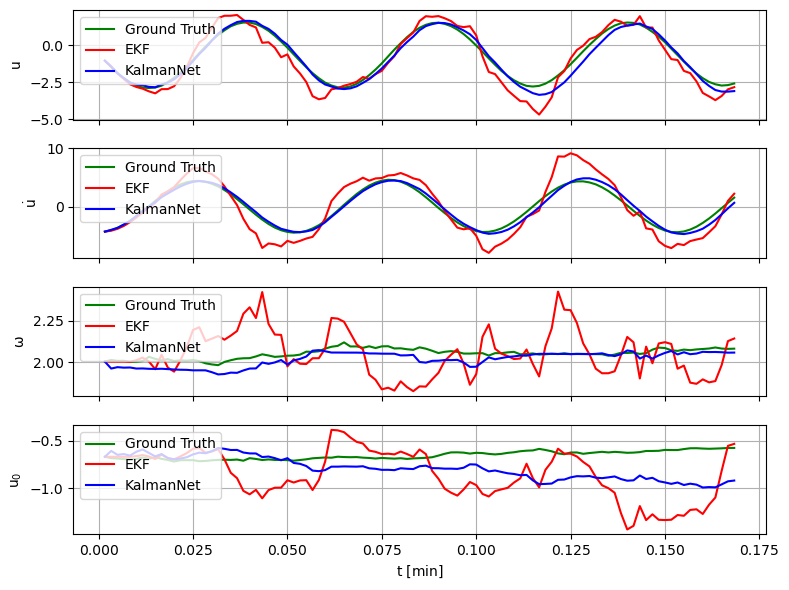

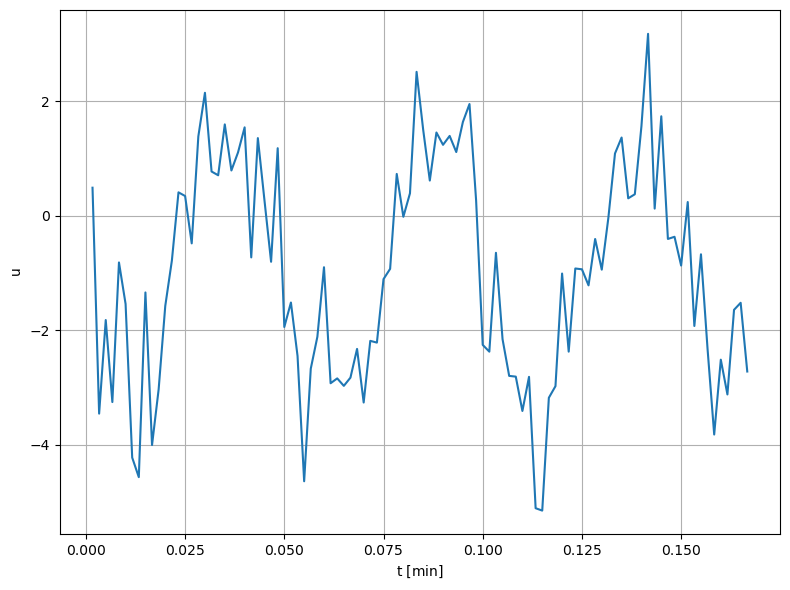

In [31]:
#Single trajectory
batch_nr = 90

random_initial_condition = test[1][batch_nr, 0, :]# + torch.normal(0, torch.sqrt(torch.Tensor([4, 4, 1, 1])))
pipeline_knet = Pipeline(knet_config.estimator_config.save_info.path, knet_name, device="cuda")
pipeline_knet.load_estimator()
pipeline_knet.set_loss_function(knet_config.estimator_config.loss)
estimates_knet = pipeline_knet.get_estimates(test[2][batch_nr, :, :], random_initial_condition)

pipeline_ekf = Pipeline(ekf_config.estimator_config.save_info.path, ekf_name)
pipeline_ekf.load_estimator()
pipeline_ekf.set_loss_function(ekf_config.estimator_config.loss)
estimates_ekf = pipeline_ekf.get_estimates(test[2][batch_nr, :, :], random_initial_condition)

# Plot different estimates of specific batch
estimates_dict = {'Ground Truth': test[1][batch_nr, :, :],
                  'EKF': estimates_ekf,
                  'KalmanNet': estimates_knet}

plot.set_figsize((8, 6))
plot.set_fontsize(10)
plot.set_add_plot_name('t100_late_not_ri')
plot.plot_state_estimates(estimates_dict,printable_states=[0, 1, 2, 3], style_dict=style_dict, color_dict=color_dict, save_plot=True, legend_loc='upper left')
plot.plot_observation_trajectory(test[2][batch_nr, :, :])

In [19]:
# Longer trajectory
pipeline_knet.set_device("cuda")
estimates_knet_long = pipeline_knet.get_estimates_complete(test[2], initial_state=test[1][0, 0, :])
pipeline_ekf.set_device("cpu")
estimates_ekf_long = pipeline_ekf.get_estimates_complete(test[2], initial_state=test[1][0, 0, :])

test_target_flatten = torch.flatten(test[1][:, 1:, :], start_dim=0, end_dim=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


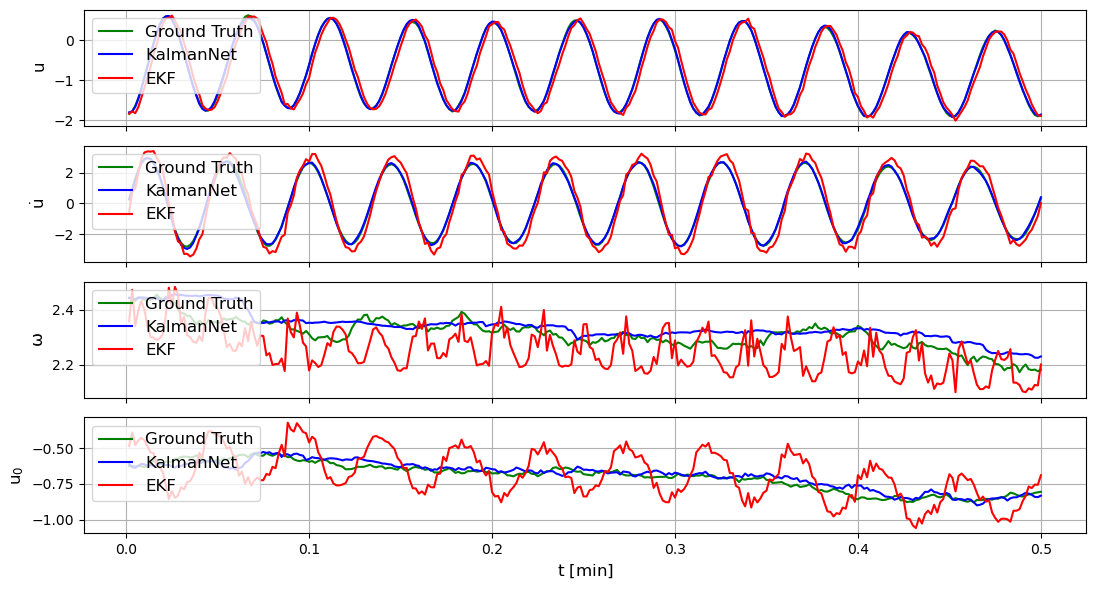

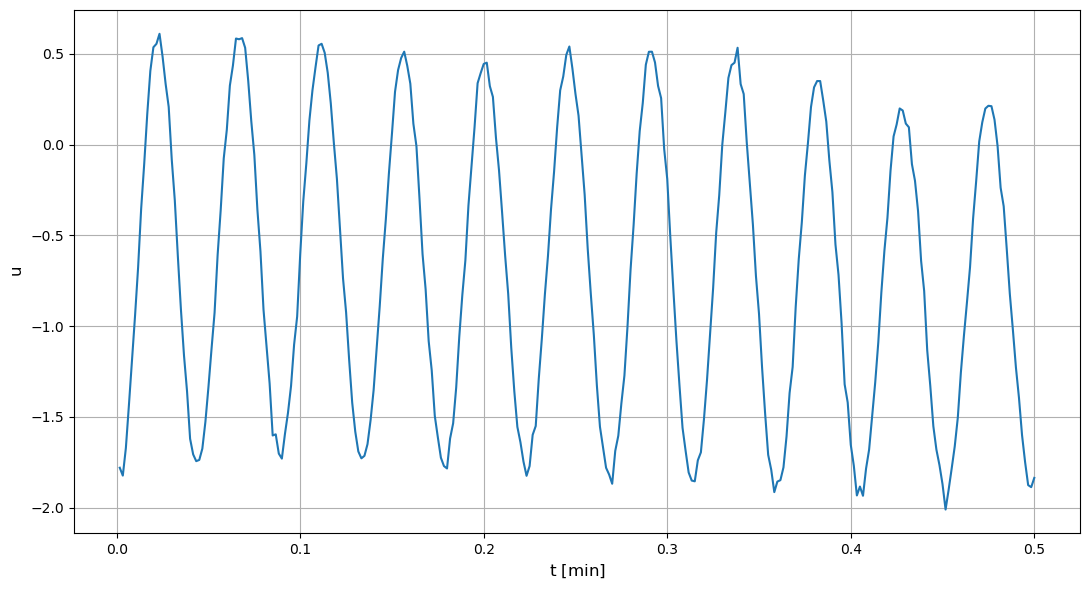

In [25]:
seq_start = 9700
seq_end = 10000
plot.set_figsize((11, 6))
plot.set_fontsize(12)
estimates_dict = {'Ground Truth': test_target_flatten[seq_start:seq_end],
                  'KalmanNet': estimates_knet_long[seq_start:seq_end],
                  'EKF': estimates_ekf_long[seq_start:seq_end]}
plot.set_add_plot_name("test_state_trajectory_stable")
plot.plot_state_estimates(estimates_dict, printable_states=[0, 1, 2, 3], color_dict=color_dict, style_dict=style_dict, save_plot=True, legend_loc='upper left')
test_input_flatten = torch.flatten(test[2], start_dim=0, end_dim=1)
plot.set_add_plot_name("observation_trajectory_r1e-1")
plot.plot_observation_trajectory(test_input_flatten[seq_start:seq_end], save_plot=False)

In [72]:
filter_dict = {'loss_name': "defMSE", 'n_features': 1, 'train_random_variance': 'None',
               'test_random_variance': 'None',
               'estimator_type': 'ExtendedKalmanFilter',
               'process_variance': 1e-4,
               'trajectory_length': 10000}

results = get_min_loss('data/results', 'results', 'measurement_variance', filter_dict)
results

,estimator_type,n_features,trajectory_length,process_variance,measurement_variance,loss_name,loss_in_dB,loss_std_in_dB,state_loss_in_dB,state_loss_std_in_dB,data_config,training_config,data_name,model_name,time,train_random_variance,test_random_variance
130,ExtendedKalmanFilter,1,10000,0.0001,1.000,defMSE,-0.598387,0.0,[ -5.08436397 4.89833225 -16.03139314 -12.14...,[0. 0. 0. 0.],"DataConfig(config_name='len250_r1_longtest', g...",None,"data_sr1e-01_q1e-04_r1e+00_j5_train[200,250]_v...",ExtendedKalmanFilter_data_sr1e-01_q1e-04_r1e+0...,2023-01-10T17:01:45,None,None
131,ExtendedKalmanFilter,1,10000,0.0001,0.100,defMSE,-5.976360,0.0,[-13.65718276 -0.42152525 -17.70574279 -13.69...,[0. 0. 0. 0.],DataConfig(config_name='len250_r1e-1_longtest'...,None,"data_sr1e-01_q1e-04_r1e-01_j5_train[200,250]_v...",ExtendedKalmanFilter_data_sr1e-01_q1e-04_r1e-0...,2023-01-10T17:01:56,None,None
132,ExtendedKalmanFilter,1,10000,0.0001,0.010,defMSE,-9.358981,0.0,[-21.70187723 -3.93961841 -18.64796266 -14.03...,[0. 0. 0. 0.],DataConfig(config_name='len250_r1e-2_longtest'...,None,"data_sr1e-01_q1e-04_r1e-02_j5_train[200,250]_v...",ExtendedKalmanFilter_data_sr1e-01_q1e-04_r1e-0...,2023-01-10T17:02:06,None,None
133,ExtendedKalmanFilter,1,10000,0.0001,0.001,defMSE,-10.529893,0.0,[-30.01886415 -5.13441352 -19.79676283 -14.43...,[0. 0. 0. 0.],DataConfig(config_name='len250_r1e-3_longtest'...,None,"data_sr1e-01_q1e-04_r1e-03_j5_train[200,250]_v...",ExtendedKalmanFilter_data_sr1e-01_q1e-04_r1e-0...,2023-01-10T17:02:17,None,None


In [6]:
filter_dict = {'loss_name': "defMSE", 'n_features': 1, 'train_random_variance': 'None',
               'data_config': 'train_set='+str(knet_config.data_config.train_set),
               'estimator_type': 'KalmanNetNN',
               'training_config': "loss='velMSE'",
               'process_variance': 1e-4,
               'trajectory_length': 100}

results = get_min_loss('data/results', 'results', 'measurement_variance', filter_dict)
results

,estimator_type,n_features,trajectory_length,process_variance,measurement_variance,loss_name,loss_in_dB,loss_std_in_dB,state_loss_in_dB,state_loss_std_in_dB,data_config,training_config,data_name,model_name,time,train_random_variance,test_random_variance
260,KalmanNetNN,1,100,0.0001,1.000,defMSE,-6.381956,1.790888,[ -5.99176778 -4.0901304 -21.6266458 -5.65...,[0.90092974 3.00923354 2.70819019 1.08039337],"DataConfig(config_name='default_r1', generate=...",TrainingConfig(config_name='default_velMSE_wd1...,"data_sr1e-01_q1e-04_r1e+00_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-23T09:08:33,None,None
268,KalmanNetNN,1,100,0.0001,0.100,defMSE,-10.848939,2.111630,[-15.34413977 -5.87264103 -17.20404147 -16.56...,[1.52465745 2.33061349 2.55503521 1.79238442],"DataConfig(config_name='default_r1e-1', genera...",TrainingConfig(config_name='default_velMSE_lr5...,"data_sr1e-01_q1e-04_r1e-01_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-23T09:11:29,None,None
276,KalmanNetNN,1,100,0.0001,0.010,defMSE,-13.855121,2.830897,[-21.73024233 -8.75640046 -17.53249701 -21.47...,[2.30254793 3.05168727 2.50429807 2.55935349],"DataConfig(config_name='default_r1e-2', genera...",TrainingConfig(config_name='default_velMSE_lr5...,"data_sr1e-01_q1e-04_r1e-02_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-23T09:14:23,None,None
286,KalmanNetNN,1,100,0.0001,0.001,defMSE,-19.296550,4.385227,[-28.38982321 -14.34004291 -22.33867231 -25.32...,[3.96358303 4.53554275 4.22623836 3.60490204],"DataConfig(config_name='default_r1e-3', genera...","TrainingConfig(config_name='default_velMSE', n...","data_sr1e-01_q1e-04_r1e-03_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-23T09:17:17,None,None


In [16]:
filter_dict = {'loss_name': "defMSE", 'n_features': 1, 'train_random_variance': '[4, 4, 1, 1]',
               'data_config': 'train_set='+str(knet_config.data_config.train_set),
               'estimator_type': 'KalmanNetNN',
               'training_config': "loss='MSE'",
               'process_variance': 1e-4,
               'trajectory_length': 100}

results = get_min_loss('data/results', 'results', 'measurement_variance', filter_dict)
results

,estimator_type,n_features,trajectory_length,process_variance,measurement_variance,loss_name,loss_in_dB,loss_std_in_dB,state_loss_in_dB,state_loss_std_in_dB,data_config,training_config,data_name,model_name,time,train_random_variance,test_random_variance
233,KalmanNetNN,1,100,0.0001,1.000,defMSE,-4.906354,1.299724,[ -6.26473944 -0.04466862 -16.37167041 -13.63...,[0.9903968 1.45466008 3.13720198 1.77179937],"DataConfig(config_name='default_r1', generate=...",TrainingConfig(config_name='default_wd1e-4_ri'...,"data_sr1e-01_q1e-04_r1e+00_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:38:19,"[4, 4, 1, 1]",None
241,KalmanNetNN,1,100,0.0001,0.100,defMSE,-11.638396,1.134604,[-15.45477044 -6.47116109 -19.16028142 -20.79...,[0.97927782 1.22541001 2.36874908 1.7973044 ],"DataConfig(config_name='default_r1e-1', genera...",TrainingConfig(config_name='default_wd1e-4_ri'...,"data_sr1e-01_q1e-04_r1e-01_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:45:36,"[4, 4, 1, 1]",None
247,KalmanNetNN,1,100,0.0001,0.010,defMSE,-20.951098,2.018022,[-25.32509932 -16.04407043 -26.31728475 -26.99...,[1.26756026 2.26470176 2.46634004 2.43201333],"DataConfig(config_name='default_r1e-2', genera...",TrainingConfig(config_name='default_lr5e-4_ri'...,"data_sr1e-01_q1e-04_r1e-02_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:47:46,"[4, 4, 1, 1]",None
257,KalmanNetNN,1,100,0.0001,0.001,defMSE,-24.564695,1.731331,[-33.15635582 -19.94937902 -27.62464599 -27.81...,[0.98695351 1.97415428 2.24605974 2.1052064 ],"DataConfig(config_name='default_r1e-3', genera...",TrainingConfig(config_name='default_wd1e-4_ri'...,"data_sr1e-01_q1e-04_r1e-03_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:51:22,"[4, 4, 1, 1]",None


In [42]:
filter_dict = {'loss_name': "defMSE", 'training_config': "loss='MSE'", 'n_features': 1,
                'data_config': 'train_set='+str(knet_config.data_config.train_set),
               'train_random_variance': '[4, 4, 1, 1]', 'test_random_variance': 'None',
               'estimator_type': 'KalmanNetNN', 'process_variance': 1e-4, 'trajectory_length': 100}

results = get_min_loss('data/results', 'results', 'measurement_variance', filter_dict)
results

,estimator_type,n_features,trajectory_length,process_variance,measurement_variance,loss_name,loss_in_dB,loss_std_in_dB,state_loss_in_dB,state_loss_std_in_dB,data_config,training_config,data_name,model_name,time,train_random_variance,test_random_variance
233,KalmanNetNN,1,100,0.0001,1.000,defMSE,-4.906354,1.299724,[ -6.26473944 -0.04466862 -16.37167041 -13.63...,[0.9903968 1.45466008 3.13720198 1.77179937],"DataConfig(config_name='default_r1', generate=...",TrainingConfig(config_name='default_wd1e-4_ri'...,"data_sr1e-01_q1e-04_r1e+00_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:38:19,"[4, 4, 1, 1]",None
241,KalmanNetNN,1,100,0.0001,0.100,defMSE,-11.638396,1.134604,[-15.45477044 -6.47116109 -19.16028142 -20.79...,[0.97927782 1.22541001 2.36874908 1.7973044 ],"DataConfig(config_name='default_r1e-1', genera...",TrainingConfig(config_name='default_wd1e-4_ri'...,"data_sr1e-01_q1e-04_r1e-01_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:45:36,"[4, 4, 1, 1]",None
247,KalmanNetNN,1,100,0.0001,0.010,defMSE,-20.951098,2.018022,[-25.32509932 -16.04407043 -26.31728475 -26.99...,[1.26756026 2.26470176 2.46634004 2.43201333],"DataConfig(config_name='default_r1e-2', genera...",TrainingConfig(config_name='default_lr5e-4_ri'...,"data_sr1e-01_q1e-04_r1e-02_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:47:46,"[4, 4, 1, 1]",None
257,KalmanNetNN,1,100,0.0001,0.001,defMSE,-24.564695,1.731331,[-33.15635582 -19.94937902 -27.62464599 -27.81...,[0.98695351 1.97415428 2.24605974 2.1052064 ],"DataConfig(config_name='default_r1e-3', genera...",TrainingConfig(config_name='default_wd1e-4_ri'...,"data_sr1e-01_q1e-04_r1e-03_j5_train[500,100]_v...",KalmanNetNN_lossMSE_ep100_train4000_val1000_te...,2023-01-22T22:51:22,"[4, 4, 1, 1]",None


In [48]:
filter_dict = {'loss_name': "velMSE", 'training_config': "'velMSE'", 'n_features': 1,
               'train_random_variance': 'None', 'estimator_type': 'KalmanNetNN', 'process_variance': 1e-4, 'trajectory_length': 100}

results = get_min_loss('data/results', 'results', 'measurement_variance', filter_dict)
results

,estimator_type,n_features,trajectory_length,process_variance,measurement_variance,loss_name,loss_in_dB,loss_std_in_dB,state_loss_in_dB,state_loss_std_in_dB,data_config,training_config,data_name,model_name,time,train_random_variance,test_random_variance
200,KalmanNetNN,1,100,0.0001,1.000,velMSE,-4.090130,3.009234,[ -5.99176778 -4.0901304 -21.6266458 -5.65...,[0.90092974 3.00923354 2.70819019 1.08039337],"DataConfig(config_name='default_r1', generate=...",TrainingConfig(config_name='default_velMSE_wd1...,"data_sr1e-01_q1e-04_r1e+00_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-21T21:39:26,None,None
207,KalmanNetNN,1,100,0.0001,0.100,velMSE,-5.872641,2.330613,[-15.34413977 -5.87264103 -17.20404147 -16.56...,[1.52465745 2.33061349 2.55503521 1.79238442],"DataConfig(config_name='default_r1e-1', genera...",TrainingConfig(config_name='default_velMSE_lr5...,"data_sr1e-01_q1e-04_r1e-01_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-22T02:31:32,None,None
215,KalmanNetNN,1,100,0.0001,0.010,velMSE,-8.756400,3.051687,[-21.73024233 -8.75640046 -17.53249701 -21.47...,[2.30254793 3.05168727 2.50429807 2.55935349],"DataConfig(config_name='default_r1e-2', genera...",TrainingConfig(config_name='default_velMSE_lr5...,"data_sr1e-01_q1e-04_r1e-02_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-22T08:14:30,None,None
222,KalmanNetNN,1,100,0.0001,0.001,velMSE,-14.340043,4.535543,[-28.38982321 -14.34004291 -22.33867231 -25.32...,[3.96358303 4.53554275 4.22623836 3.60490204],"DataConfig(config_name='default_r1e-3', genera...","TrainingConfig(config_name='default_velMSE', n...","data_sr1e-01_q1e-04_r1e-03_j5_train[500,100]_v...",KalmanNetNN_lossvelMSE_ep100_train4000_val1000...,2023-01-22T12:58:54,None,None


In [ ]:
filter_dict = {'loss_name': "defMSE", 'training_config': "'velocity_MSE'", 'n_features': 1,
               'estimator_name': 'KalmanNetNN', 'process_variance': 1e-4}

results = get_min_loss('data/results/results.csv', 'measurement_variance', filter_dict)
results

In [ ]:

# # plot.plot_estimates(test[1][0, seq_start:seq_end, :], torch.permute(KNet_test,(0, 2, 1))[0, seq_start:seq_end, :].cpu().detach().numpy())
# plot.plot_estimates(test_target_flatten[seq_start:seq_end, :], estimates[seq_start:seq_end, :])
# plot.plot_estimates(train_target_flatten[seq_start:seq_end, :], estimates_train[seq_start:seq_end, :])

In [ ]:
# model_gpu = GerstnerWavesGPU()
# sys_model = Sysmodel(model_gpu.f_discrete, torch.zeros((4, 4)), model_gpu.h_cor,
#                                 torch.Tensor([1]), 100, 200)
#                                 # prior_Q=torch.zeros((4, 4)), prior_Sigma=torch.zeros((4, 4)),
#                                 # prior_S=torch.Tensor([[0]]))
# sys_model.InitSequence(torch.ones(4), torch.eye(4) * 0 * 0)
# KNet_Pipeline = Pipeline_EKF('', model_folder_name, model_name)
#
# k_net = torch.load(model_folder_name + '/model_' + model_name + ".pt")
# KNet_Pipeline.setModel(k_net)
# KNet_Pipeline.setssModel(sys_model)
# test_input = torch.permute(test[2], (0, 2, 1))
# test_target = torch.permute(test[1], (0, 2, 1))[:, :, 1:]
# [KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg,KNet_test] = KNet_Pipeline.NNTest(test_input, test_target)

In [ ]:
# process_covariance = 0.01 *torch.eye(4)
# measurement_covariance = torch.tensor([[1]])
# kalman_filter = ExtendedKalmanFilter(model.get_continuous_state_evolution_callable(), model.get_measurement_matrix(), process_covariance, measurement_covariance, n_taylor_coefficients=5)
# kalman_filter.set_initial_conditions(torch.ones(4), torch.zeros((4, 4)))
# x_estimated=kalman_filter.estimate_state_from_observations(test[2][1, : ,:])
# GerstnerWavesPlots.plot_estimates(test[0], test[1][1, :, :], x_estimated)

In [ ]:
# train_input = torch.permute(test[2], (0, 2, 1))
# train_target = torch.permute(test[1], (0, 2, 1))
# sys_model = Sysmodel(model.f_discrete, process_covariance, model.h_cor,
#                                 measurement_covariance, 100, 200)
# sys_model.InitSequence(torch.ones(4), torch.zeros((4, 4)))
#
# [MSE_EKF_linear_arr, MSE_EKF_linear_avg, MSE_EKF_dB_avg, EKF_KG_array, EKF_out] = EKFTest(sys_model, train_input,
#                                                                                                   train_target[:, :, 1:])
# EKF_out = torch.permute(EKF_out, (0, 2, 1))
# GerstnerWavesPlots.plot_estimates(test[0][1:].cpu(), test[1][1, 1:, :].cpu(), EKF_out[1, :, :].cpu())
# EKF_out = torch.permute(EKF_out, (0, 2, 1)).cpu()
# train_target = train_target.cpu()